# VAE Inference for DESI Sky Spectra

This notebook demonstrates how to use the pretrained Variational Autoencoder (VAE) for DESI sky spectra. The VAE is a key component of the Latent Diffusion Model (LDM) pipeline and can be used for:

- **Encoding** sky spectra into compact latent representations
- **Decoding** latent vectors back to sky spectra
- **Reconstruction** to assess how well the VAE captures spectral features
- **Anomaly detection** via reconstruction error
- **Latent space analysis** to understand sky variability

## Setup

In [1]:
import jax
import jax.numpy as jnp
import jax.random as jr
import numpy as np
import matplotlib.pyplot as plt
import desisky
from desisky.io import load_builtin
from desisky.data import SkySpecVAC

## 1. Load Pretrained VAE

The VAE comes with pretrained weights that can be loaded using the `load_builtin` function:

In [2]:
# Load the pretrained VAE
vae, meta = load_builtin("vae")

print("VAE Architecture:")
print(f"  Input channels: {meta['arch']['in_channels']}")
print(f"  Latent dimension: {meta['arch']['latent_dim']}")
print(f"\nModel schema version: {meta['schema']}")

VAE Architecture:
  Input channels: 7781
  Latent dimension: 8

Model schema version: 0


## 2. Load Sky Spectra Data

Let's load some real DESI sky spectra to work with:

In [3]:
# Load the sky spectra value-added catalog
vac = SkySpecVAC(version='v1.0', download=True)
wavelength, flux, metadata = vac.load()

print(f"Loaded {flux.shape[0]} sky spectra")
print(f"Wavelength range: {wavelength.min():.1f} - {wavelength.max():.1f} Å")
print(f"Spectrum shape: {flux.shape}")

Loaded 9176 sky spectra
Wavelength range: 3600.0 - 9824.0 Å
Spectrum shape: (9176, 7781)


## 3. Basic VAE Operations

### 3.1 Encode a Single Spectrum

The VAE encoder maps a sky spectrum to a distribution in latent space (mean and log-variance):

In [4]:
# Select a single spectrum
single_spectrum = flux[0].squeeze()

# Encode to latent distribution parameters
mean, logvar = vae.encode(single_spectrum)

print(f"Latent mean shape: {mean.shape}")
print(f"Latent mean: {mean}")
print(f"\nLatent logvar shape: {logvar.shape}")
print(f"Latent std: {jnp.exp(0.5 * logvar)}")

Latent mean shape: (8,)
Latent mean: [ 1.2363297  -0.75002134 11.379927    6.5341635  -3.9925961  -3.6680381
  6.9365005  -7.5973563 ]

Latent logvar shape: (8,)
Latent std: [0.03428241 0.11253308 1.0491956  0.04579925 0.03226947 0.03584523
 0.03447815 0.03742665]


### 3.2 Sample from Latent Space

Using the reparameterization trick, we can sample a latent vector:

In [5]:
# Sample a latent vector
key = jr.PRNGKey(42)
latent = vae.sample(mean, logvar, key)

print(f"Sampled latent: {latent}")

Sampled latent: [ 1.2353593  -0.69745356 11.690177    6.541196   -3.9965987  -3.6602626
  6.8868217  -7.569067  ]


### 3.3 Decode Latent Vector

The decoder reconstructs a sky spectrum from a latent vector:

In [6]:
# Decode latent to reconstructed spectrum
reconstructed = vae.decode(latent)

print(f"Reconstructed spectrum shape: {reconstructed.shape}")

Reconstructed spectrum shape: (7781,)


### 3.4 Full Forward Pass

You can also do encoding, sampling, and decoding in one call:

In [7]:
# Full forward pass
result = vae(single_spectrum, key)

print("Result keys:", result.keys())
print(f"  mean: {result['mean'].shape}")
print(f"  logvar: {result['logvar'].shape}")
print(f"  latent: {result['latent'].shape}")
print(f"  output: {result['output'].shape}")

Result keys: dict_keys(['mean', 'logvar', 'latent', 'output'])
  mean: (8,)
  logvar: (8,)
  latent: (8,)
  output: (7781,)


## 4. Batch Processing

For efficiency, you can process multiple spectra at once using `jax.vmap`:

In [8]:
# Process a batch of spectra
batch = flux.squeeze()  # Remove channel dimension if present

# Encode entire batch
batch_means, batch_logvars = jax.vmap(vae.encode)(batch)
print(f"Batch means shape: {batch_means.shape}")
print(f"Batch logvars shape: {batch_logvars.shape}")

# Sample latents for entire batch
batch_keys = jr.split(key, len(batch))
batch_latents = jax.vmap(vae.sample)(batch_means, batch_logvars, batch_keys)
print(f"Batch latents shape: {batch_latents.shape}")

# Decode entire batch
batch_reconstructed = jax.vmap(vae.decode)(batch_latents)
print(f"Batch reconstructed shape: {batch_reconstructed.shape}")

Batch means shape: (9176, 8)
Batch logvars shape: (9176, 8)
Batch latents shape: (9176, 8)
Batch reconstructed shape: (9176, 7781)


## 5. Visualizing Reconstructions

Let's compare the original and reconstructed spectra:

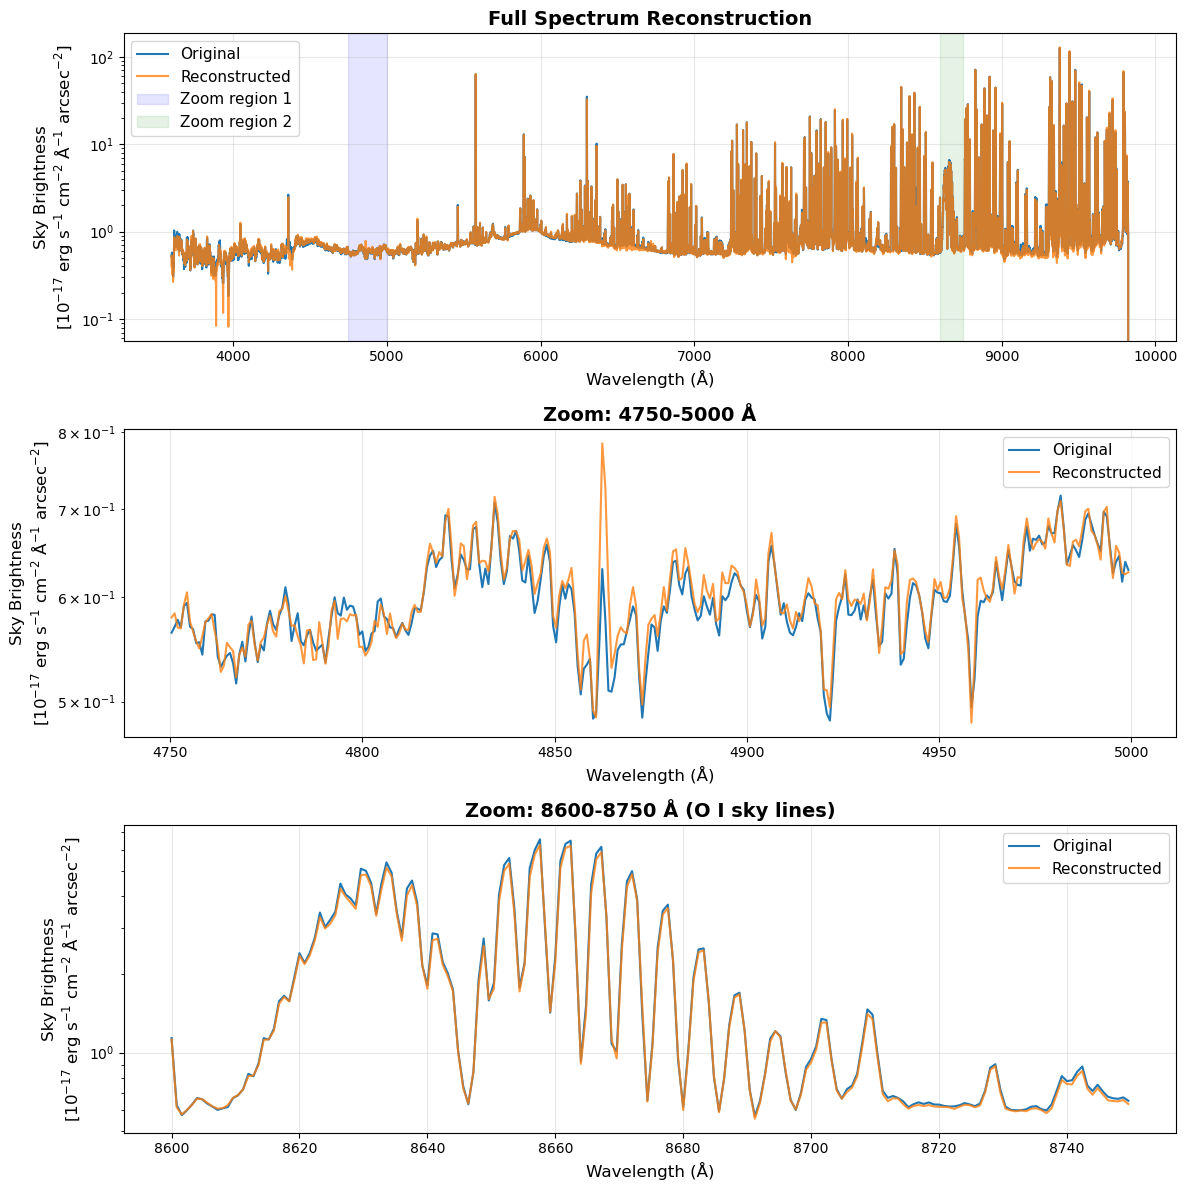

In [9]:
fig, axs = plt.subplots(3, 1, figsize=(12, 12))

# Full spectrum
axs[0].plot(wavelength, batch[0], label='Original', linewidth=1.5)
axs[0].plot(wavelength, batch_reconstructed[0], label='Reconstructed', linewidth=1.5, alpha=0.8)
axs[0].axvspan(4750, 5000, color='blue', alpha=0.1, label='Zoom region 1')
axs[0].axvspan(8600, 8750, color='green', alpha=0.1, label='Zoom region 2')
axs[0].set_yscale('log')
axs[0].set_xlabel('Wavelength (Å)', fontsize=12)
axs[0].set_ylabel('Sky Brightness\n[$10^{-17}$ erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$ arcsec$^{-2}$]', fontsize=12)
axs[0].set_title('Full Spectrum Reconstruction', fontsize=14, fontweight='bold')
axs[0].legend(fontsize=11)
axs[0].grid(alpha=0.3)

# Zoom 1: 4750-5000 Å
i0 = np.searchsorted(wavelength, 4750)
i1 = np.searchsorted(wavelength, 5000)
axs[1].plot(wavelength[i0:i1], batch[0, i0:i1], label='Original', linewidth=1.5)
axs[1].plot(wavelength[i0:i1], batch_reconstructed[0, i0:i1], label='Reconstructed', linewidth=1.5, alpha=0.8)
axs[1].set_yscale('log')
axs[1].set_xlabel('Wavelength (Å)', fontsize=12)
axs[1].set_ylabel('Sky Brightness\n[$10^{-17}$ erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$ arcsec$^{-2}$]', fontsize=12)
axs[1].set_title('Zoom: 4750-5000 Å', fontsize=14, fontweight='bold')
axs[1].legend(fontsize=11)
axs[1].grid(alpha=0.3)

# Zoom 2: 8600-8750 Å
i0 = np.searchsorted(wavelength, 8600)
i1 = np.searchsorted(wavelength, 8750)
axs[2].plot(wavelength[i0:i1], batch[0, i0:i1], label='Original', linewidth=1.5)
axs[2].plot(wavelength[i0:i1], batch_reconstructed[0, i0:i1], label='Reconstructed', linewidth=1.5, alpha=0.8)
axs[2].set_yscale('log')
axs[2].set_xlabel('Wavelength (Å)', fontsize=12)
axs[2].set_ylabel('Sky Brightness\n[$10^{-17}$ erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$ arcsec$^{-2}$]', fontsize=12)
axs[2].set_title('Zoom: 8600-8750 Å (O I sky lines)', fontsize=14, fontweight='bold')
axs[2].legend(fontsize=11)
axs[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Reconstruction Error Analysis

Reconstruction error can be used to identify unusual sky spectra:

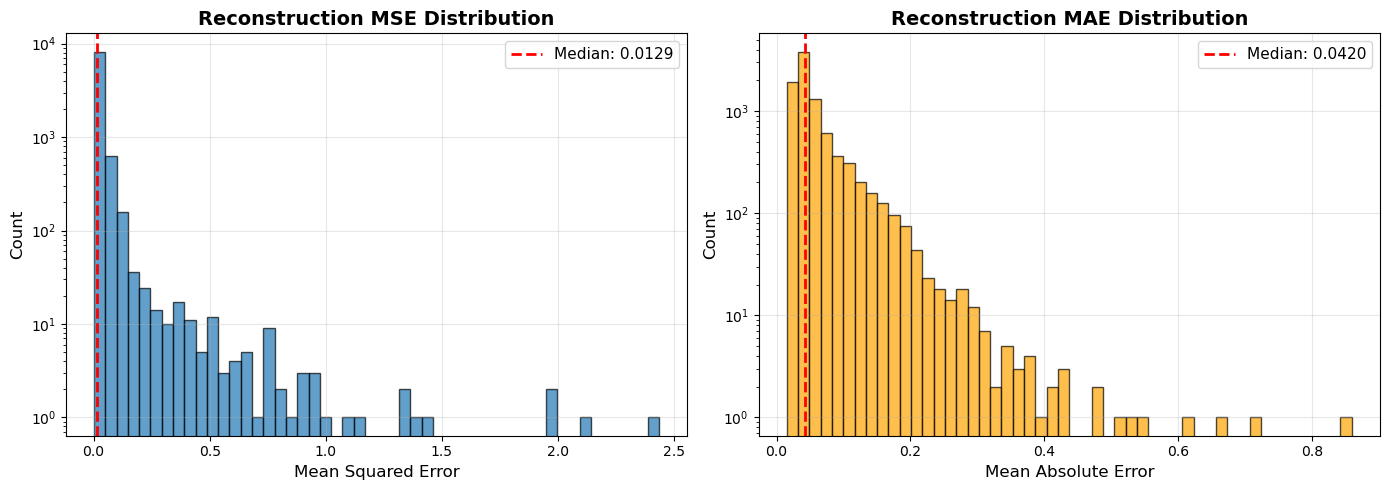


Reconstruction Error Statistics:
  MSE: 0.0286 ± 0.0805
  MAE: 0.0583 ± 0.0469

Potential anomalies (MSE > 95th percentile): 459 spectra


In [10]:
# Calculate reconstruction errors
mse = jnp.mean((batch - batch_reconstructed)**2, axis=1)
mae = jnp.mean(jnp.abs(batch - batch_reconstructed), axis=1)

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# MSE distribution
axs[0].hist(mse, bins=50, alpha=0.7, edgecolor='black')
axs[0].axvline(jnp.median(mse), color='red', linestyle='--', linewidth=2, label=f'Median: {jnp.median(mse):.4f}')
axs[0].set_xlabel('Mean Squared Error', fontsize=12)
axs[0].set_ylabel('Count', fontsize=12)
axs[0].set_title('Reconstruction MSE Distribution', fontsize=14, fontweight='bold')
axs[0].set_yscale('log')
axs[0].legend(fontsize=11)
axs[0].grid(alpha=0.3)

# MAE distribution
axs[1].hist(mae, bins=50, alpha=0.7, edgecolor='black', color='orange')
axs[1].axvline(jnp.median(mae), color='red', linestyle='--', linewidth=2, label=f'Median: {jnp.median(mae):.4f}')
axs[1].set_xlabel('Mean Absolute Error', fontsize=12)
axs[1].set_ylabel('Count', fontsize=12)
axs[1].set_title('Reconstruction MAE Distribution', fontsize=14, fontweight='bold')
axs[1].set_yscale('log')
axs[1].legend(fontsize=11)
axs[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nReconstruction Error Statistics:")
print(f"  MSE: {jnp.mean(mse):.4f} ± {jnp.std(mse):.4f}")
print(f"  MAE: {jnp.mean(mae):.4f} ± {jnp.std(mae):.4f}")

# Find potential anomalies (high reconstruction error)
threshold = jnp.percentile(mse, 95)
anomaly_indices = jnp.where(mse > threshold)[0]
print(f"\nPotential anomalies (MSE > 95th percentile): {len(anomaly_indices)} spectra")

## 7. Summary

This notebook demonstrated the basic usage of the DESI sky spectra VAE:

1. ✅ Loading pretrained VAE weights with `load_builtin("vae")`
2. ✅ Encoding spectra to latent representations
3. ✅ Sampling from and decoding latent space
4. ✅ Batch processing with `jax.vmap`
5. ✅ Visualizing reconstructions
6. ✅ Analyzing reconstruction errors for anomaly detection

### Next Steps

For advanced analysis including:
- Latent space visualization and interpolation
- Correlation with physical parameters (moon phase, sun altitude, etc.)
- Condition-specific performance analysis

See the **04_vae_analysis.ipynb** notebook (coming in PR #2).